In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
df = pd.read_excel('Dados\RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
print(df.head())

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\Renan\AppData\Local\Temp\ipykernel_22680\698182482.py:1: SyntaxWarning: invalid escape sequence '\R'
  df = pd.read_excel('Dados\RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')


    Ano  Lula_art  Lula_ind  Lula_art_ind  Lula_oceanica_art  Calamar_ind  \
0  1950       NaN       NaN           NaN                NaN          NaN   
1  1951       NaN       NaN           NaN                NaN          NaN   
2  1952       NaN       NaN           NaN                NaN          NaN   
3  1953       NaN       NaN           NaN                NaN          NaN   
4  1954       NaN       NaN           NaN                NaN          NaN   

   Polvo_art  Polvo_ind  Polvo_art_ind  Polvo_cabecinha_art  ...  \
0        NaN        NaN            NaN                  NaN  ...   
1        NaN        NaN            NaN                  NaN  ...   
2        NaN        NaN            NaN                  NaN  ...   
3        NaN        NaN            NaN                  NaN  ...   
4        NaN        NaN            NaN                  NaN  ...   

   Mexilhao_ind  Mexilhao_mangue_art  Caramujo_art  Caramujo_ind  Vieira_ind  \
0           NaN                  NaN           N

In [3]:
x0 = df[['Ano', 'Polvo_art']].dropna().values
x1 = df[['Ano', 'Polvo_ind']].dropna().values


In [4]:
df_x0= pd.DataFrame(x0, columns= ['Ano', 'Polvo_art'])
df_x1=pd.DataFrame(x1, columns= ['Ano', 'Polvo_ind'])
df_x0= df_x0.drop_duplicates(subset= 'Polvo_art')
df_x1= df_x1.drop_duplicates(subset='Polvo_ind')

In [5]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Polvo_art'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

In [6]:
def leaky_relu(x):
    return tf.nn.RMSprop(x, alpha=0.01)

In [7]:
class PrintEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, N):
        super(PrintEveryNEpochs, self).__init__()
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.2086009979248047
Epoch 200: loss = 0.09018292278051376
Epoch 300: loss = 0.06075237691402435
Epoch 400: loss = 0.05005716532468796
Epoch 500: loss = 0.05286265164613724
Epoch 600: loss = 0.041702982038259506
Epoch 700: loss = 0.037072934210300446
Epoch 800: loss = 0.02725137397646904
Epoch 900: loss = 0.028713760897517204
Epoch 1000: loss = 0.025036875158548355
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


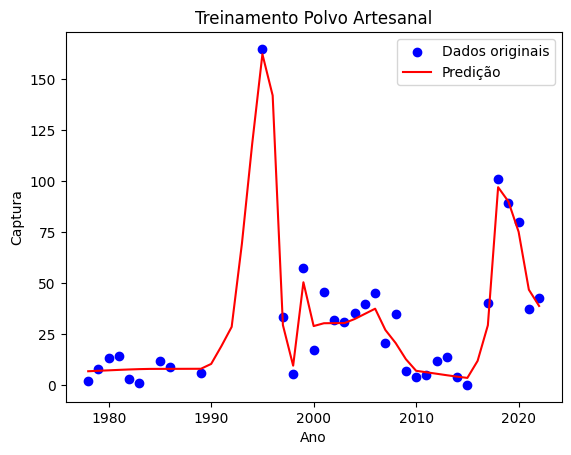

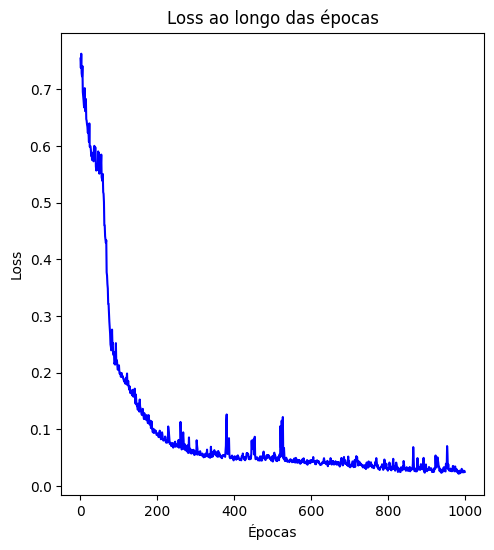

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])


print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=1000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Polvo Artesanal')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predição para o ano 1969: 4.475290298461914
Predição para o ano 1970: 4.791296005249023
Predição para o ano 1971: 5.06492805480957
Predição para o ano 1972: 5.334541320800781
Predição para o ano 1973: 5.567598342895508
Predição para o ano 1974: 5.800298690795898
Predição para o ano 1975: 6.032991409301758
Predição para o ano 1976: 6.265666961669922
Predição para o ano 1977: 6.49748420715332
Predição para o ano 1990: 10.323118209838867
Predição para o ano 1991: 19.085094451904297
Predição para o ano 1992: 28.51825714111328
Predição para o ano 1993: 69.38578796386719
Predição para o ano 1994: 118.28556823730469
Predição para o ano 2016: 11.829429626464844


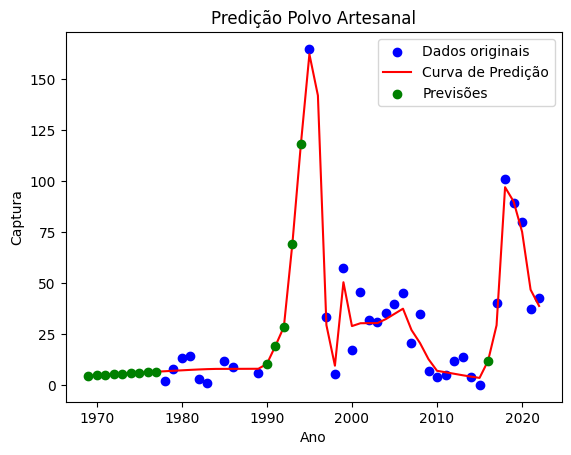

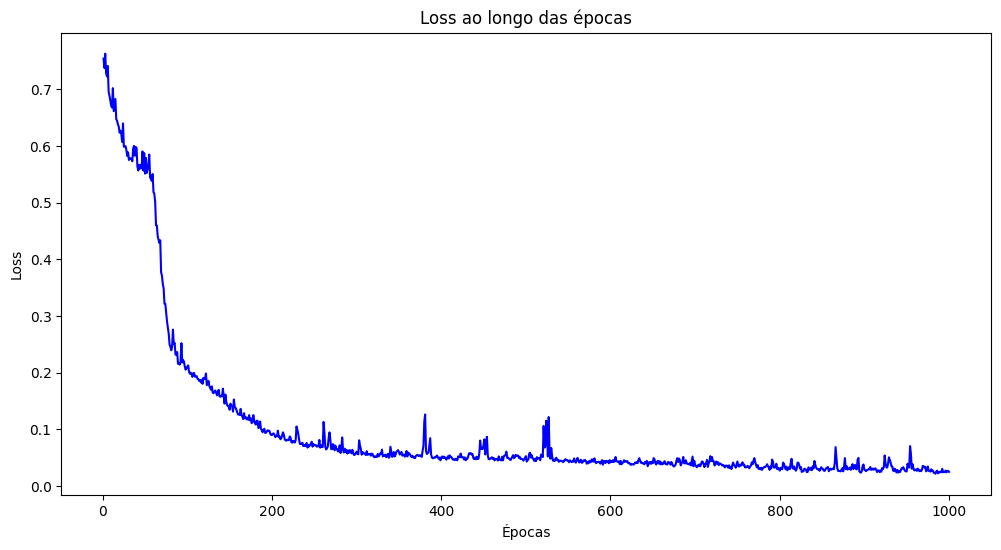

In [9]:
anos_para_prever = np.array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1990, 1991, 1992, 1993, 1994, 2016]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Polvo Artesanal')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

In [10]:
df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
print(df_combined)
df_combined.to_excel('DataFrame_reconstruido/Polvo_artesanal_reconstruido.xlsx', index=False)

       Ano  Captura Original  Captura Preditos
0   1969.0               NaN          4.475290
1   1970.0               NaN          4.791296
2   1971.0               NaN          5.064928
3   1972.0               NaN          5.334541
4   1973.0               NaN          5.567598
5   1974.0               NaN          5.800299
6   1975.0               NaN          6.032991
7   1976.0               NaN          6.265667
8   1977.0               NaN          6.497484
9   1978.0          2.000000               NaN
10  1979.0          8.000000               NaN
11  1980.0         13.000000               NaN
12  1981.0         14.000000               NaN
13  1982.0          3.000000               NaN
14  1983.0          1.000000               NaN
15  1985.0         12.000000               NaN
16  1986.0          9.000000               NaN
17  1989.0          6.000000               NaN
18  1990.0               NaN         10.323118
19  1991.0               NaN         19.085094
20  1992.0   

POLVO INDUSTRIAL

In [11]:
x = np.array(df_x1['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x1['Polvo_ind'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

Epoch 100: loss = 0.2740192711353302
Epoch 200: loss = 0.10232891142368317
Epoch 300: loss = 0.03658368065953255
Epoch 400: loss = 0.027934085577726364
Epoch 500: loss = 0.024779194965958595
Epoch 600: loss = 0.02833743765950203
Epoch 700: loss = 0.021778233349323273
Epoch 800: loss = 0.01929285190999508
Epoch 900: loss = 0.020219868049025536
Epoch 1000: loss = 0.013200854882597923
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


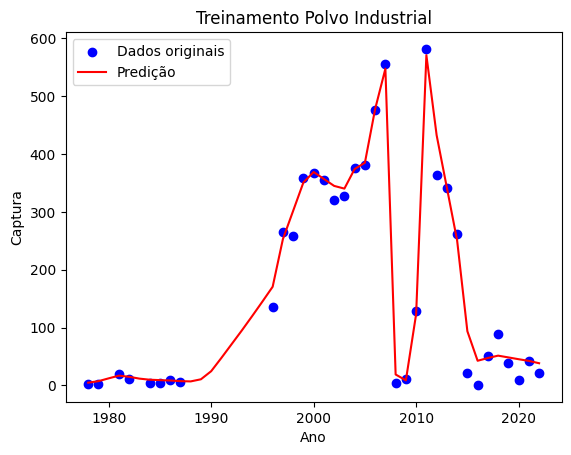

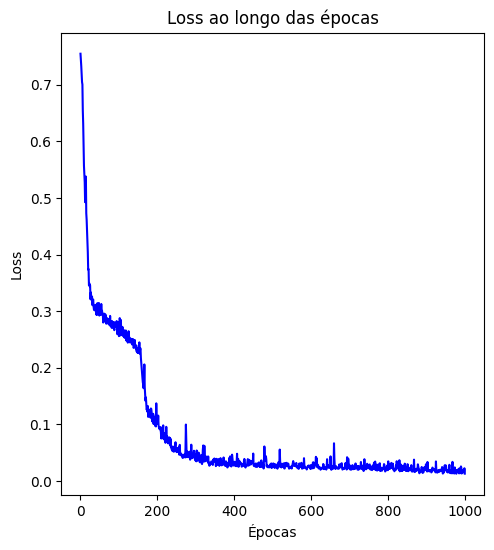

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=1000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Polvo Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predição para o ano 1969: -12.044342041015625
Predição para o ano 1970: -10.868453979492188
Predição para o ano 1971: -9.36895751953125
Predição para o ano 1972: -7.8365325927734375
Predição para o ano 1973: -6.9011993408203125
Predição para o ano 1974: -4.933502197265625
Predição para o ano 1975: -2.97442626953125
Predição para o ano 1976: -1.01336669921875
Predição para o ano 1977: 1.284393310546875
Predição para o ano 1983: 11.836090087890625
Predição para o ano 1990: 24.664810180664062
Predição para o ano 1991: 47.716400146484375
Predição para o ano 1992: 71.5040512084961
Predição para o ano 1993: 95.31519317626953
Predição para o ano 1994: 119.94026947021484
Predição para o ano 1995: 145.05072021484375


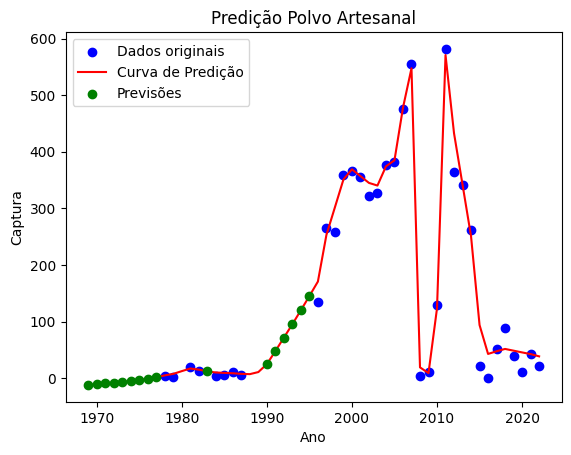

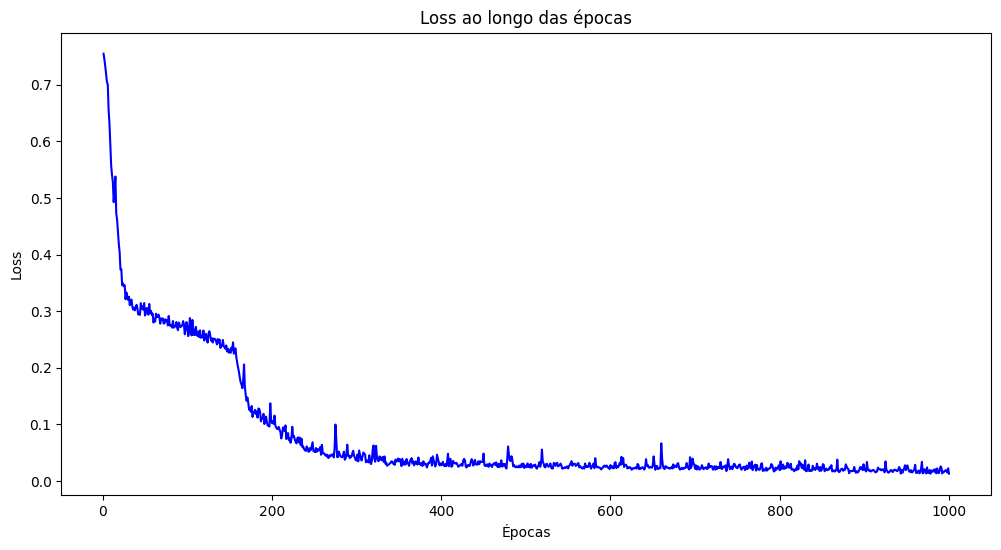

In [14]:
anos_para_prever = np.array([1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1983, 1990, 1991, 1992, 1993, 1994, 1995]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Predição Polvo Artesanal')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

In [15]:
import pandas as pd
import numpy as np

df_originais = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_preditos = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.merge(df_originais, df_preditos, on='Ano', how='outer').sort_values(by='Ano')
df_combined['Captura Original'] = df_combined['Captura Original'].clip(lower=0)
df_combined['Captura Preditos'] = df_combined['Captura Preditos'].clip(lower=0)
print(df_combined)
df_combined.to_excel('DataFrame_reconstruido/Polvo_industrial_reconstruido.xlsx', index=False)


       Ano  Captura Original  Captura Preditos
0   1969.0               NaN          0.000000
1   1970.0               NaN          0.000000
2   1971.0               NaN          0.000000
3   1972.0               NaN          0.000000
4   1973.0               NaN          0.000000
5   1974.0               NaN          0.000000
6   1975.0               NaN          0.000000
7   1976.0               NaN          0.000000
8   1977.0               NaN          1.284393
9   1978.0          3.000000               NaN
10  1979.0          2.000000               NaN
11  1981.0         20.000000               NaN
12  1982.0         12.000000               NaN
13  1983.0               NaN         11.836090
14  1984.0          4.000000               NaN
15  1985.0          5.000000               NaN
16  1986.0         10.000000               NaN
17  1987.0          6.000000               NaN
18  1990.0               NaN         24.664810
19  1991.0               NaN         47.716400
20  1992.0   

POLVO TOTAL

In [16]:
df_1 = pd.read_excel('DataFrame_reconstruido\Polvo_artesanal_reconstruido.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Renan\AppData\Local\Temp\ipykernel_22680\1092864650.py:1: SyntaxWarning: invalid escape sequence '\P'
  df_1 = pd.read_excel('DataFrame_reconstruido\Polvo_artesanal_reconstruido.xlsx')


In [17]:
x0 = pd.DataFrame(df_1[['Ano', 'Captura Original']].fillna(0).values, columns=['Ano', 'Captura Original'])
x1 = pd.DataFrame(df_1[['Ano', 'Captura Preditos']].fillna(0).values, columns=['Ano', 'Captura Preditos'])

In [18]:
resultado = x0['Captura Original'] + x1['Captura Preditos']

novo_df1 = pd.DataFrame({'Ano': df_1['Ano'], 'Lula_art': resultado})

print(novo_df1)

     Ano    Lula_art
0   1969    4.475290
1   1970    4.791296
2   1971    5.064928
3   1972    5.334541
4   1973    5.567598
5   1974    5.800299
6   1975    6.032991
7   1976    6.265667
8   1977    6.497484
9   1978    2.000000
10  1979    8.000000
11  1980   13.000000
12  1981   14.000000
13  1982    3.000000
14  1983    1.000000
15  1985   12.000000
16  1986    9.000000
17  1989    6.000000
18  1990   10.323118
19  1991   19.085094
20  1992   28.518257
21  1993   69.385788
22  1994  118.285568
23  1995  165.000000
24  1997   33.500000
25  1998    5.500000
26  1999   57.500000
27  2000   17.000000
28  2001   45.500000
29  2002   32.000000
30  2003   31.000000
31  2004   35.500000
32  2005   39.500000
33  2006   45.000000
34  2007   20.500000
35  2008   35.041000
36  2009    7.000000
37  2010    3.728000
38  2011    4.711000
39  2012   11.939000
40  2013   13.802000
41  2014    3.823000
42  2015    0.008000
43  2016   11.829430
44  2017   40.427551
45  2018  101.038300
46  2019   89

In [19]:
df_2 = pd.read_excel('DataFrame_reconstruido\Polvo_industrial_reconstruido.xlsx')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Renan\AppData\Local\Temp\ipykernel_22680\4077111323.py:1: SyntaxWarning: invalid escape sequence '\P'
  df_2 = pd.read_excel('DataFrame_reconstruido\Polvo_industrial_reconstruido.xlsx')


In [20]:
x2 = pd.DataFrame(df_2[['Ano', 'Captura Original']].fillna(0).values, columns=['Ano', 'Captura Original'])
x3 = pd.DataFrame(df_2[['Ano', 'Captura Preditos']].fillna(0).values, columns=['Ano', 'Captura Preditos'])

In [24]:
resultado_2 = x2['Captura Original'] + x3['Captura Preditos']

novo_df_2 = pd.DataFrame({'Ano': df_2['Ano'], 'Lula_ind': resultado_2})

print(novo_df_2)

     Ano    Lula_ind
0   1969    0.000000
1   1970    0.000000
2   1971    0.000000
3   1972    0.000000
4   1973    0.000000
5   1974    0.000000
6   1975    0.000000
7   1976    0.000000
8   1977    0.000000
9   1978    3.000000
10  1979    2.000000
11  1981   20.000000
12  1982   12.000000
13  1983    0.000000
14  1984    4.000000
15  1985    5.000000
16  1986   10.000000
17  1987    6.000000
18  1990   28.598953
19  1991   41.060699
20  1992   54.939423
21  1993   68.429199
22  1994   85.196899
23  1995  107.765381
24  1996  135.000000
25  1997  265.000000
26  1998  258.500000
27  1999  359.500000
28  2000  366.500000
29  2001  355.500000
30  2002  321.000000
31  2003  327.500000
32  2004  376.000000
33  2005  381.500000
34  2006  476.000000
35  2007  555.500000
36  2008    4.284000
37  2009   10.863000
38  2010  128.988998
39  2011  581.804993
40  2012  363.782990
41  2013  341.524994
42  2014  261.919006
43  2015   22.264999
44  2016    0.944000
45  2017   51.736301
46  2018   89

In [21]:
resultado = x0['Captura Original'] + x1['Captura Preditos'] + x2['Captura Original'] + x3['Captura Preditos']

Polvo_total = pd.DataFrame({'Ano': df_1['Ano'], 'Polvo_total': resultado}).dropna()

print(Polvo_total)

       Ano  Polvo_total
0   1969.0     4.475290
1   1970.0     4.791296
2   1971.0     5.064928
3   1972.0     5.334541
4   1973.0     5.567598
5   1974.0     5.800299
6   1975.0     6.032991
7   1976.0     6.265667
8   1977.0     7.781878
9   1978.0     5.000000
10  1979.0    10.000000
11  1980.0    33.000000
12  1981.0    26.000000
13  1982.0    14.836090
14  1983.0     5.000000
15  1985.0    17.000000
16  1986.0    19.000000
17  1989.0    12.000000
18  1990.0    34.987928
19  1991.0    66.801495
20  1992.0   100.022308
21  1993.0   164.700981
22  1994.0   238.225838
23  1995.0   310.050720
24  1997.0   168.500000
25  1998.0   270.500000
26  1999.0   316.000000
27  2000.0   376.500000
28  2001.0   412.000000
29  2002.0   387.500000
30  2003.0   352.000000
31  2004.0   363.000000
32  2005.0   415.500000
33  2006.0   426.500000
34  2007.0   497.000000
35  2008.0   590.541000
36  2009.0    11.284000
37  2010.0    14.591000
38  2011.0   133.699998
39  2012.0   593.743993
40  2013.0   377

In [22]:
x = np.array(Polvo_total['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(Polvo_total['Polvo_total'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

Epoch 100: loss = 0.3189277648925781
Epoch 200: loss = 0.2758758068084717
Epoch 300: loss = 0.34561416506767273
Epoch 400: loss = 0.23716801404953003
Epoch 500: loss = 0.21007294952869415
Epoch 600: loss = 0.19410519301891327
Epoch 700: loss = 0.2512838542461395
Epoch 800: loss = 0.10423528403043747
Epoch 900: loss = 0.2453424334526062
Epoch 1000: loss = 0.16271163523197174
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002DE231A7380> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to ht

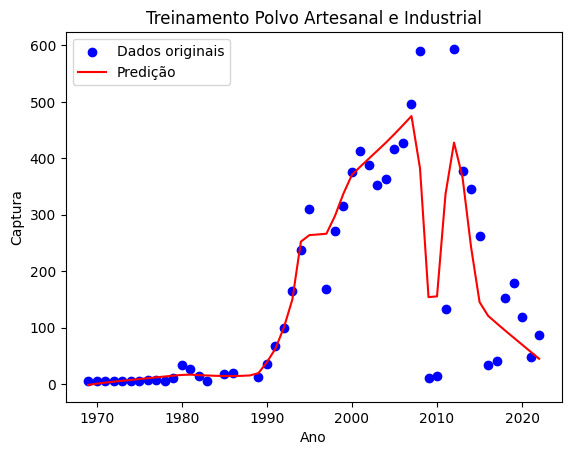

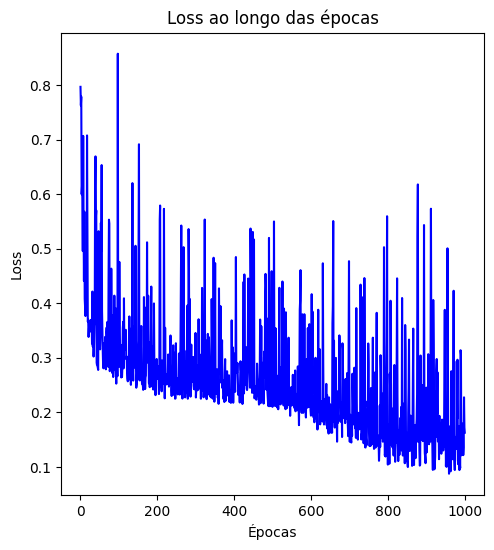

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=1000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Polvo Artesanal e Industrial')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()
